In [3]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import log_loss

In [5]:
# load raw financial data
# hourly resolution
gamestop_data = pd.read_csv('../foobar/data/raw/stock_candle_60_2020-03-01_2021-03-01.csv')
gamestop_data = gamestop_data.sort_values(by=['timestamp'], axis=0)
gamestop_data['hour'] = pd.to_datetime(gamestop_data['timestamp'], unit='s')
gamestop_data = gamestop_data.set_index('hour')

# resmaple the data hourly and pad the gaps with the previous record
gamestop_data = gamestop_data.resample('H', label='right').pad()
print(gamestop_data.shape)
gamestop_data = gamestop_data.rename(
                        columns={
                            "close_price": "closeprice",
                            "open_price": "openprice",
                            "high-price": "highprice",
                            "low-price": "lowprice"
                        }
                    )

train_data = gamestop_data[gamestop_data.index.year == 2020]
short_squeeze_data = gamestop_data[gamestop_data.index.year == 2021]
print(train_data.shape)
print(short_squeeze_data.shape)
train_data.columns

(7692, 8)
(6395, 8)
(1297, 8)


Index(['Unnamed: 0', 'closeprice', 'highprice', 'lowprice', 'openprice',
       'status', 'timestamp', 'volume'],
      dtype='object')

## Data Preprocessing

In [13]:
# create train and test dataset
# sorted based on timestamp 

# extract timestamps for visualization
train_datetime_list = list(train_data.index)
target_datetime_list = list(short_squeeze_data.index)
gamestop_datetime_list = list(gamestop_data.index)

# reordering the columns: put the prediction column to the last column
cols = ['openprice', 'highprice', 'lowprice', 'volume', 'closeprice']
df_train = train_data[cols]
df_target = short_squeeze_data[cols]
df_gamestop = gamestop_data[cols]

out = df_gamestop.copy()
out['prediction'] = np.nan
out.to_csv('../foobar/data/processed/gme.csv')
# check the df column types to ensure they have correct types
print(df_train.dtypes)
cols
out

openprice     float64
highprice     float64
lowprice      float64
volume          int64
closeprice    float64
dtype: object


,openprice,highprice,lowprice,volume,closeprice,prediction
hour,,,,,,
2020-04-09 13:00:00,3.450,3.72,3.450,319130,3.70,NaN
2020-04-09 14:00:00,3.700,3.90,3.685,620809,3.86,NaN
2020-04-09 15:00:00,3.865,4.08,3.800,1023287,4.06,NaN
2020-04-09 16:00:00,4.060,4.19,3.890,602239,4.12,NaN
2020-04-09 17:00:00,4.130,4.25,3.870,1006734,4.03,NaN
...,...,...,...,...,...,...
2021-02-23 20:00:00,44.910,45.40,44.000,835553,44.92,NaN
2021-02-23 21:00:00,44.970,45.13,42.900,379831,43.21,NaN
2021-02-23 22:00:00,43.240,43.55,42.660,125100,43.00,NaN


<AxesSubplot:xlabel='hour'>

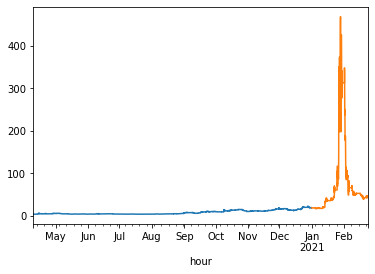

In [8]:
df_train['closeprice'].plot()
df_target['closeprice'].plot()

In [9]:
# finding missing values
df_train.isnull().sum()

openprice     0
highprice     0
lowprice      0
volume        0
closeprice    0
dtype: int64

In [10]:
df_target.isnull().sum()

openprice     0
highprice     0
lowprice      0
volume        0
closeprice    0
dtype: int64

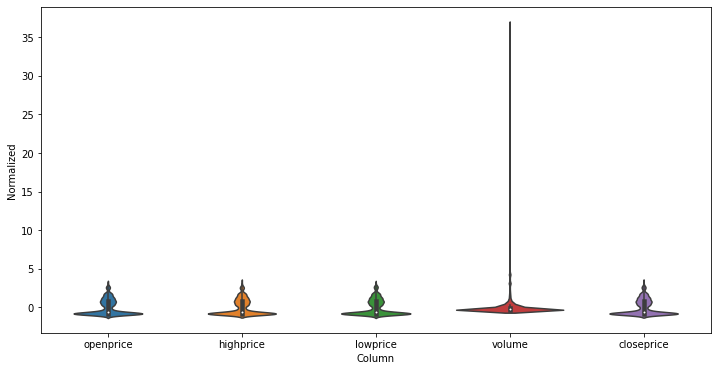

In [11]:
# Visualize the ditribution of the features in the train dataset
df_std = (df_train - df_train.mean()) / df_train.std()
df_std = df_std.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)


In [79]:
def scale(df, feature_set, scaler=None):
    if scaler is None:
        scaler = StandardScaler()
        scaled_arr = scaler.fit_transform(df[feature_set])
    else:
        scaled_arr = scaler.transform(df[feature_set])
    return scaled_arr, scaler

def split(train_arr, train_ratio):
    # split the data to train, validate
    n = len(train_arr)
    train_set = train_arr[:int(n*train_ratio)]
    val_set = train_arr[int(n*train_ratio):]
    return train_set, val_set

### Data Windowing for time series forecasting

> Refer to [Data Windowing](https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing) for more details


In [80]:
# Generate time windows for time series forecasting with LSTM network
def generate_window(dataset, train_window, pred_horizon):
    dataset_seq = []
    size = len(dataset)
    x_arr = []
    y_arr = []
    for i in range(size - train_window - pred_horizon):
        x = dataset[i:(i+train_window), :-1]
        y = dataset[i+train_window+pred_horizon-1:i+train_window+pred_horizon, -1]
        x_arr.append(x)
        y_arr.append(y)

    x_tensor = torch.tensor(x_arr).float()
    y_tensor = torch.tensor(y_arr).float()
    num_features = x_tensor.shape[2]
    dataset_seq = (x_tensor, y_tensor)
    return dataset_seq, num_features

def create_batch_set(dataset_seq):
    x_tensor, y_tensor = dataset_seq
    tensor_dataset = TensorDataset(x_tensor,y_tensor)
    batch_size = 100
    tensor_dataloader = DataLoader(tensor_dataset, batch_size, False)
    return tensor_dataloader

In [95]:
# various feature sets for model selection
feature_set1 = ['open_price', 'high-price', 'low-price', 'volume', 'close_price']
feature_set2 = ['open_price', 'high-price', 'low-price', 'close_price']
feature_set3 = ['open_price', 'volume', 'close_price']
feature_set4 = ['volume', 'close_price']
feature_sets = [feature_set1, feature_set1, feature_set3, feature_set4]

# let's create sequential training dataset with various traning windows and prediction horizons
# given that the times series data has 1-hour resolution
# 24hours * (days)
train_window_list = 24 * np.array([5, 10, 30])
prediction_horizon_list = 24 * np.array([1, 2, 3, 5, 10])


train_set, train_scaler = scale(df_train, feature_sets[0])
target_set, _ = scale(df_target, feature_sets[0], train_scaler)
train_set , val_set = split(train_set, 0.8)

gamestop_set, _ = scale(df_gamestop, feature_sets[0], train_scaler)

train_window = train_window_list[0]
prediction_horizon = prediction_horizon_list[0]

train_seq, num_features = generate_window(train_set, train_window, prediction_horizon)
val_seq, _ = generate_window(val_set, train_window, prediction_horizon)

train_batches = create_batch_set(train_seq)
val_batches = create_batch_set(val_seq)

target_seq, _ = generate_window(target_set, train_window, prediction_horizon)
gamestop_seq, _ = generate_window(gamestop_set, train_window, prediction_horizon)

datetime_target = target_datetime_list[train_window+prediction_horizon:]
datetime_gamestop = gamestop_datetime_list[train_window+prediction_horizon:]


## Creating LSTM Network

In [17]:
class LSTM(nn.Module):
    def __init__(self, input_size, seq_length, hidden_size=100, num_layers = 2, output_size=1):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.seq_len = seq_length
        
        self.hidden_state = None
        self.cell_state = None
        self.hidden = (self.hidden_state, self.cell_state)

        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=0.2,
            batch_first=True
        )

        self.linear = nn.Linear(self.hidden_size * self.seq_len, self.output_size)

    def init_hidden(self, batch_size, device):
        self.hidden_state = torch.zeros(self.num_layers, batch_size ,self.hidden_size).to(device)
        self.cell_state = torch.zeros(self.num_layers, batch_size ,self.hidden_size).to(device)
        self.hidden = (self.hidden_state, self.cell_state)

    def forward(self, x, forecast_timesteps = 0):
        batch_size = x.size(0)
        lstm_out, self.hidden = self.lstm(
                x,
                self.hidden
            )
        outputs = self.linear(lstm_out.reshape(batch_size,-1))
        return outputs


## Traning LSTM model

In [70]:
def train_model(model, device, train_batches, val_batches=None, num_epochs=200):

    learning_rate = 1e-3
    best_loss = np.Inf
    val_loss = None
    history = dict(train=[], val=[])

    criterion = torch.nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        train_losses = []
        for batch_ndx, train_batch in enumerate(train_batches):
            model.train()
            x_train, y_train = train_batch
            batch_size = x_train.size(0)
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            model.init_hidden(batch_size, device)
            outputs = model(x_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss = loss.item()
            train_losses.append(train_loss)
            
            if val_batches is not None:
                with torch.no_grad():
                    model.eval()
                    val_losses = []
                    for _, val_batch in enumerate(val_batches):
                        x_val, y_val = val_batch
                        batch_size = x_val.size(0)
                        x_val = x_val.to(device)
                        y_val = y_val.to(device)
                        model.init_hidden(batch_size, device)
                        pred = model(x_val)
                        loss = criterion(pred, y_val)
                        val_loss = loss.item()
                        val_losses.append(val_loss)
                        if val_loss < best_loss:
                            best_loss = val_loss
                        if val_loss < 0.05:
                            break
            print(f'Batch {batch_ndx} Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        history['val'].append(np.mean(val_losses)) 
        history['train'].append(np.mean(train_losses)) 
            
            
    print(f"best validation loss = {best_loss}")        
    return model.eval(), history, best_loss

In [71]:
def visualization(history):
    plt.plot(history['train'], label="Training loss")
    plt.plot(history['val'], label="Test loss")
    plt.legend()

In [72]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

model = LSTM(input_size=num_features, seq_length=train_window)
model.to(device)

model, history, best_loss = train_model(model, device, train_batches, val_batches, num_epochs=50)

Batch 0 Epoch 0: train loss 0.4875347912311554 val loss 7.767407417297363
Batch 1 Epoch 0: train loss 0.07683544605970383 val loss 9.48511028289795
Batch 2 Epoch 0: train loss 0.023724498227238655 val loss 10.579541206359863
Batch 3 Epoch 0: train loss 0.3328097462654114 val loss 10.543086051940918
Batch 4 Epoch 0: train loss 0.17985093593597412 val loss 9.91950511932373
Batch 5 Epoch 0: train loss 0.0010585663840174675 val loss 9.367132186889648
Batch 6 Epoch 0: train loss 0.054466474801301956 val loss 8.942644119262695
Batch 7 Epoch 0: train loss 0.16070938110351562 val loss 8.637377738952637
Batch 8 Epoch 0: train loss 0.11010316759347916 val loss 8.408267974853516
Batch 9 Epoch 0: train loss 0.08868589252233505 val loss 8.245092391967773
Batch 10 Epoch 0: train loss 0.03649991750717163 val loss 8.106904029846191
Batch 11 Epoch 0: train loss 0.01050518173724413 val loss 7.969880104064941
Batch 12 Epoch 0: train loss 0.001995294587686658 val loss 7.843054294586182
Batch 13 Epoch 0: t

Batch 10 Epoch 2: train loss 0.08361922204494476 val loss 14.171777725219727
Batch 11 Epoch 2: train loss 0.07488628476858139 val loss 14.076006889343262
Batch 12 Epoch 2: train loss 0.05967174842953682 val loss 13.808561325073242
Batch 13 Epoch 2: train loss 0.07507988810539246 val loss 13.383956909179688
Batch 14 Epoch 2: train loss 0.016923798248171806 val loss 12.899100303649902
Batch 15 Epoch 2: train loss 0.0034526598174124956 val loss 12.413152694702148
Batch 16 Epoch 2: train loss 0.08638620376586914 val loss 12.040716171264648
Batch 17 Epoch 2: train loss 0.0934230387210846 val loss 11.79967212677002
Batch 18 Epoch 2: train loss 0.08292943984270096 val loss 11.701533317565918
Batch 19 Epoch 2: train loss 0.07505515217781067 val loss 11.744991302490234
Batch 20 Epoch 2: train loss 0.06625499576330185 val loss 11.923321723937988
Batch 21 Epoch 2: train loss 0.04075680673122406 val loss 12.204258918762207
Batch 22 Epoch 2: train loss 0.028256721794605255 val loss 12.5700807571411

Batch 19 Epoch 4: train loss 0.08651621639728546 val loss 10.493163108825684
Batch 20 Epoch 4: train loss 0.09556003659963608 val loss 10.625870704650879
Batch 21 Epoch 4: train loss 0.08066173642873764 val loss 10.723808288574219
Batch 22 Epoch 4: train loss 0.0777539536356926 val loss 10.78750991821289
Batch 23 Epoch 4: train loss 0.04731299355626106 val loss 10.816852569580078
Batch 24 Epoch 4: train loss 0.016850359737873077 val loss 10.820268630981445
Batch 25 Epoch 4: train loss 0.0013279467821121216 val loss 10.809545516967773
Batch 26 Epoch 4: train loss 0.014455579221248627 val loss 10.808897018432617
Batch 27 Epoch 4: train loss 0.03776482865214348 val loss 10.829625129699707
Batch 28 Epoch 4: train loss 0.07004021853208542 val loss 10.880834579467773
Batch 29 Epoch 4: train loss 0.10314767807722092 val loss 10.952253341674805
Batch 30 Epoch 4: train loss 0.08909499645233154 val loss 11.020768165588379
Batch 31 Epoch 4: train loss 0.06887239962816238 val loss 11.0689926147460

Batch 27 Epoch 6: train loss 0.0033337650820612907 val loss 56.86941909790039
Batch 28 Epoch 6: train loss 0.00542596448212862 val loss 57.94301986694336
Batch 29 Epoch 6: train loss 0.009460976347327232 val loss 58.2602653503418
Batch 30 Epoch 6: train loss 0.005445307586342096 val loss 58.10042953491211
Batch 31 Epoch 6: train loss 0.0056892745196819305 val loss 57.4998779296875
Batch 32 Epoch 6: train loss 0.015192939899861813 val loss 56.207313537597656
Batch 33 Epoch 6: train loss 0.1223142147064209 val loss 53.36030960083008
Batch 34 Epoch 6: train loss 0.011392812244594097 val loss 50.814083099365234
Batch 35 Epoch 6: train loss 0.12603913247585297 val loss 48.42646026611328
Batch 36 Epoch 6: train loss 0.03460242226719856 val loss 46.41064453125
Batch 37 Epoch 6: train loss 0.09366012364625931 val loss 44.213932037353516
Batch 38 Epoch 6: train loss 0.03673018515110016 val loss 41.542564392089844
Batch 39 Epoch 6: train loss 0.1172390729188919 val loss 35.96449279785156
Batch 4

Batch 35 Epoch 8: train loss 0.27490365505218506 val loss 41.64023208618164
Batch 36 Epoch 8: train loss 0.059590961784124374 val loss 39.63991165161133
Batch 37 Epoch 8: train loss 0.057327400892972946 val loss 37.606510162353516
Batch 38 Epoch 8: train loss 0.08241593092679977 val loss 33.890159606933594
Batch 39 Epoch 8: train loss 0.24127882719039917 val loss 26.748693466186523
Batch 40 Epoch 8: train loss 0.355132520198822 val loss 17.607269287109375
Batch 41 Epoch 8: train loss 0.19307172298431396 val loss 10.172204971313477
Batch 42 Epoch 8: train loss 0.16321532428264618 val loss 0.01826012320816517
Batch 43 Epoch 8: train loss 0.009307396598160267 val loss 0.014956760220229626
Batch 44 Epoch 8: train loss 0.031047264114022255 val loss 0.0118170864880085
Batch 45 Epoch 8: train loss 0.014607779681682587 val loss 0.02229023352265358
Batch 46 Epoch 8: train loss 0.0970897376537323 val loss 0.016379080712795258
Batch 47 Epoch 8: train loss 0.07962475717067719 val loss 0.0337384007

Batch 44 Epoch 10: train loss 0.016192132607102394 val loss 0.010865534655749798
Batch 45 Epoch 10: train loss 0.003109475364908576 val loss 0.01147445384413004
Batch 46 Epoch 10: train loss 0.13275255262851715 val loss 0.017061756923794746
Batch 47 Epoch 10: train loss 0.14394378662109375 val loss 0.03628866747021675
Batch 48 Epoch 10: train loss 0.03171810507774353 val loss 0.028667163103818893
Batch 49 Epoch 10: train loss 0.09741930663585663 val loss 0.02911754511296749
Batch 0 Epoch 11: train loss 0.06423018872737885 val loss 0.045025765895843506
Batch 1 Epoch 11: train loss 0.06923496723175049 val loss 0.2261558175086975
Batch 2 Epoch 11: train loss 0.08426883816719055 val loss 0.30111607909202576
Batch 3 Epoch 11: train loss 0.014758226461708546 val loss 0.3646329641342163
Batch 4 Epoch 11: train loss 0.030445890501141548 val loss 0.41279181838035583
Batch 5 Epoch 11: train loss 0.08191413432359695 val loss 0.4310757517814636
Batch 6 Epoch 11: train loss 0.09198710322380066 val 

Batch 0 Epoch 13: train loss 0.0635736808180809 val loss 0.3826011121273041
Batch 1 Epoch 13: train loss 0.06130364164710045 val loss 0.48357272148132324
Batch 2 Epoch 13: train loss 0.07158634066581726 val loss 0.5415409803390503
Batch 3 Epoch 13: train loss 0.010511351749300957 val loss 0.5817829966545105
Batch 4 Epoch 13: train loss 0.02190493606030941 val loss 0.6029480695724487
Batch 5 Epoch 13: train loss 0.06127238646149635 val loss 0.5901483297348022
Batch 6 Epoch 13: train loss 0.07050265371799469 val loss 0.5392674803733826
Batch 7 Epoch 13: train loss 0.06630294770002365 val loss 0.45447230339050293
Batch 8 Epoch 13: train loss 0.02808140031993389 val loss 0.3589210510253906
Batch 9 Epoch 13: train loss 0.021404985338449478 val loss 0.26269084215164185
Batch 10 Epoch 13: train loss 0.00922742672264576 val loss 0.17903876304626465
Batch 11 Epoch 13: train loss 0.001531262998469174 val loss 0.11461770534515381
Batch 12 Epoch 13: train loss 0.0025101425126194954 val loss 0.0718

Batch 7 Epoch 15: train loss 0.07392704486846924 val loss 0.6417286396026611
Batch 8 Epoch 15: train loss 0.03390955552458763 val loss 0.5236459970474243
Batch 9 Epoch 15: train loss 0.024565160274505615 val loss 0.40304118394851685
Batch 10 Epoch 15: train loss 0.010963759385049343 val loss 0.2947888672351837
Batch 11 Epoch 15: train loss 0.0016574396286159754 val loss 0.20758868753910065
Batch 12 Epoch 15: train loss 0.002032824559137225 val loss 0.14531958103179932
Batch 13 Epoch 15: train loss 0.038403332233428955 val loss 0.11564420908689499
Batch 14 Epoch 15: train loss 0.02442186325788498 val loss 0.10535331815481186
Batch 15 Epoch 15: train loss 0.03274207562208176 val loss 0.11248651891946793
Batch 16 Epoch 15: train loss 0.06831197440624237 val loss 0.14550459384918213
Batch 17 Epoch 15: train loss 0.02463645488023758 val loss 0.19692522287368774
Batch 18 Epoch 15: train loss 0.01524013839662075 val loss 0.26572707295417786
Batch 19 Epoch 15: train loss 0.0031492155976593494 

Batch 12 Epoch 17: train loss 0.003366591176018119 val loss 0.09552539139986038
Batch 13 Epoch 17: train loss 0.04186215251684189 val loss 0.07682482898235321
Batch 14 Epoch 17: train loss 0.025542596355080605 val loss 0.07333232462406158
Batch 15 Epoch 17: train loss 0.03172245994210243 val loss 0.08384022116661072
Batch 16 Epoch 17: train loss 0.08108177036046982 val loss 0.1200290396809578
Batch 17 Epoch 17: train loss 0.02403726987540722 val loss 0.17509128153324127
Batch 18 Epoch 17: train loss 0.011477748863399029 val loss 0.24659772217273712
Batch 19 Epoch 17: train loss 0.001157321035861969 val loss 0.32339292764663696
Batch 20 Epoch 17: train loss 0.0012068282812833786 val loss 0.39629173278808594
Batch 21 Epoch 17: train loss 0.003903021337464452 val loss 0.4572015106678009
Batch 22 Epoch 17: train loss 0.010756760835647583 val loss 0.49719953536987305
Batch 23 Epoch 17: train loss 0.011716153472661972 val loss 0.5155260562896729
Batch 24 Epoch 17: train loss 0.01427239831537

Batch 17 Epoch 19: train loss 0.02145186811685562 val loss 0.1151658222079277
Batch 18 Epoch 19: train loss 0.007516919169574976 val loss 0.18003463745117188
Batch 19 Epoch 19: train loss 0.000590217940043658 val loss 0.24975961446762085
Batch 20 Epoch 19: train loss 0.002739488612860441 val loss 0.313818097114563
Batch 21 Epoch 19: train loss 0.007436037063598633 val loss 0.3634464144706726
Batch 22 Epoch 19: train loss 0.016369985416531563 val loss 0.39009028673171997
Batch 23 Epoch 19: train loss 0.01633279211819172 val loss 0.39397796988487244
Batch 24 Epoch 19: train loss 0.017335664480924606 val loss 0.3765258193016052
Batch 25 Epoch 19: train loss 0.015853023156523705 val loss 0.3420376777648926
Batch 26 Epoch 19: train loss 0.006985792890191078 val loss 0.3026685416698456
Batch 27 Epoch 19: train loss 0.0061648753471672535 val loss 0.2602870464324951
Batch 28 Epoch 19: train loss 0.0005752781871706247 val loss 0.22327028214931488
Batch 29 Epoch 19: train loss 0.0012714114272966

Batch 23 Epoch 21: train loss 0.02326137199997902 val loss 0.27671048045158386
Batch 24 Epoch 21: train loss 0.02256847359240055 val loss 0.2403712421655655
Batch 25 Epoch 21: train loss 0.017685143277049065 val loss 0.19306640326976776
Batch 26 Epoch 21: train loss 0.0067889331839978695 val loss 0.14753657579421997
Batch 27 Epoch 21: train loss 0.005368488375097513 val loss 0.1059863269329071
Batch 28 Epoch 21: train loss 0.00036985031329095364 val loss 0.07454074174165726
Batch 29 Epoch 21: train loss 0.0026788278482854366 val loss 0.05419914796948433
Batch 30 Epoch 21: train loss 0.006748446263372898 val loss 0.042713429778814316
Batch 31 Epoch 21: train loss 0.010380681604146957 val loss 0.038315385580062866
Batch 32 Epoch 21: train loss 0.032571692019701004 val loss 0.042840711772441864
Batch 33 Epoch 21: train loss 0.1990305632352829 val loss 0.06679938733577728
Batch 34 Epoch 21: train loss 0.06643632054328918 val loss 0.0983349084854126
Batch 35 Epoch 21: train loss 0.022787379

Batch 28 Epoch 23: train loss 0.001019331975840032 val loss 0.45019984245300293
Batch 29 Epoch 23: train loss 0.0004986075218766928 val loss 0.4186369776725769
Batch 30 Epoch 23: train loss 0.002563644200563431 val loss 0.3951462507247925
Batch 31 Epoch 23: train loss 0.0035122190602123737 val loss 0.3810327351093292
Batch 32 Epoch 23: train loss 0.020417923107743263 val loss 0.38507145643234253
Batch 33 Epoch 23: train loss 0.15198472142219543 val loss 0.4237539768218994
Batch 34 Epoch 23: train loss 0.04682598635554314 val loss 0.46448805928230286
Batch 35 Epoch 23: train loss 0.022134417667984962 val loss 0.5020246505737305
Batch 36 Epoch 23: train loss 0.033069685101509094 val loss 0.546609103679657
Batch 37 Epoch 23: train loss 0.1774788796901703 val loss 0.5991565585136414
Batch 38 Epoch 23: train loss 0.12916716933250427 val loss 0.6235378980636597
Batch 39 Epoch 23: train loss 0.10426221787929535 val loss 0.610136866569519
Batch 40 Epoch 23: train loss 0.0605422668159008 val lo

Batch 34 Epoch 25: train loss 0.047447554767131805 val loss 0.4648607075214386
Batch 35 Epoch 25: train loss 0.021493306383490562 val loss 0.5084877014160156
Batch 36 Epoch 25: train loss 0.03391946852207184 val loss 0.5600529313087463
Batch 37 Epoch 25: train loss 0.17865701019763947 val loss 0.6202815771102905
Batch 38 Epoch 25: train loss 0.1663573831319809 val loss 0.6448302865028381
Batch 39 Epoch 25: train loss 0.10748060047626495 val loss 0.6300492286682129
Batch 40 Epoch 25: train loss 0.05622638761997223 val loss 0.5898250341415405
Batch 41 Epoch 25: train loss 0.033533066511154175 val loss 0.538087010383606
Batch 42 Epoch 25: train loss 0.35229888558387756 val loss 0.4535386264324188
Batch 43 Epoch 25: train loss 0.13733111321926117 val loss 0.3227269947528839
Batch 44 Epoch 25: train loss 0.17510713636875153 val loss 0.04469548538327217
Batch 45 Epoch 25: train loss 0.15582989156246185 val loss 0.01939690113067627
Batch 46 Epoch 25: train loss 0.044185880571603775 val loss 0

Batch 40 Epoch 27: train loss 0.03925527632236481 val loss 0.48801302909851074
Batch 41 Epoch 27: train loss 0.024784760549664497 val loss 0.4625684916973114
Batch 42 Epoch 27: train loss 0.32713598012924194 val loss 0.4065839648246765
Batch 43 Epoch 27: train loss 0.11827173829078674 val loss 0.30436569452285767
Batch 44 Epoch 27: train loss 0.15192636847496033 val loss 0.04208856448531151
Batch 45 Epoch 27: train loss 0.14355750381946564 val loss 0.020353036001324654
Batch 46 Epoch 27: train loss 0.04249688610434532 val loss 0.010508078150451183
Batch 47 Epoch 27: train loss 0.05648015812039375 val loss 0.009997325949370861
Batch 48 Epoch 27: train loss 0.010372206568717957 val loss 0.013562863692641258
Batch 49 Epoch 27: train loss 0.0020440942607820034 val loss 0.019777309149503708
Batch 0 Epoch 28: train loss 0.0746343731880188 val loss 0.029490331187844276
Batch 1 Epoch 28: train loss 0.050866201519966125 val loss 0.04272748902440071
Batch 2 Epoch 28: train loss 0.042940463870763

Batch 2 Epoch 30: train loss 0.03576602041721344 val loss 1.1251944303512573
Batch 3 Epoch 30: train loss 0.007902804762125015 val loss 1.5340548753738403
Batch 4 Epoch 30: train loss 0.024356182664632797 val loss 2.017853260040283
Batch 5 Epoch 30: train loss 0.019465278834104538 val loss 2.583350658416748
Batch 6 Epoch 30: train loss 0.005077603738754988 val loss 3.2135519981384277
Batch 7 Epoch 30: train loss 0.003553129034116864 val loss 3.8201918601989746
Batch 8 Epoch 30: train loss 0.01701473817229271 val loss 4.291589260101318
Batch 9 Epoch 30: train loss 0.018568895757198334 val loss 4.5933051109313965
Batch 10 Epoch 30: train loss 0.023878516629338264 val loss 4.708707332611084
Batch 11 Epoch 30: train loss 0.026052679866552353 val loss 4.623133182525635
Batch 12 Epoch 30: train loss 0.015229742042720318 val loss 4.411227226257324
Batch 13 Epoch 30: train loss 0.028773542493581772 val loss 4.0909342765808105
Batch 14 Epoch 30: train loss 0.0007814595010131598 val loss 3.79194

Batch 7 Epoch 32: train loss 0.0022182599641382694 val loss 3.315568685531616
Batch 8 Epoch 32: train loss 0.012546615675091743 val loss 3.7802371978759766
Batch 9 Epoch 32: train loss 0.014752854593098164 val loss 4.107364177703857
Batch 10 Epoch 32: train loss 0.020929230377078056 val loss 4.272568225860596
Batch 11 Epoch 32: train loss 0.026969684287905693 val loss 4.241823673248291
Batch 12 Epoch 32: train loss 0.016598330810666084 val loss 4.079710006713867
Batch 13 Epoch 32: train loss 0.03342228755354881 val loss 3.792811393737793
Batch 14 Epoch 32: train loss 0.0028855532873421907 val loss 3.500671863555908
Batch 15 Epoch 32: train loss 0.00117427424993366 val loss 3.2397069931030273
Batch 16 Epoch 32: train loss 0.025659170001745224 val loss 3.118288993835449
Batch 17 Epoch 32: train loss 0.005380245391279459 val loss 3.057096242904663
Batch 18 Epoch 32: train loss 0.005151791963726282 val loss 3.0546839237213135
Batch 19 Epoch 32: train loss 0.0050797127187252045 val loss 3.1

Batch 11 Epoch 34: train loss 0.0244744922965765 val loss 3.9119532108306885
Batch 12 Epoch 34: train loss 0.01506128255277872 val loss 3.7533185482025146
Batch 13 Epoch 34: train loss 0.03009404055774212 val loss 3.4874534606933594
Batch 14 Epoch 34: train loss 0.002154064830392599 val loss 3.2230284214019775
Batch 15 Epoch 34: train loss 0.001203796244226396 val loss 2.992198944091797
Batch 16 Epoch 34: train loss 0.02027491107583046 val loss 2.8828792572021484
Batch 17 Epoch 34: train loss 0.005108588840812445 val loss 2.829087734222412
Batch 18 Epoch 34: train loss 0.00534840440377593 val loss 2.832043170928955
Batch 19 Epoch 34: train loss 0.005914486479014158 val loss 2.8906397819519043
Batch 20 Epoch 34: train loss 0.004878337495028973 val loss 2.994316339492798
Batch 21 Epoch 34: train loss 0.005616903305053711 val loss 3.1466915607452393
Batch 22 Epoch 34: train loss 0.004035354126244783 val loss 3.3400473594665527
Batch 23 Epoch 34: train loss 0.0007708746707066894 val loss 3

Batch 17 Epoch 36: train loss 0.007588095963001251 val loss 2.064178466796875
Batch 18 Epoch 36: train loss 0.007593465968966484 val loss 2.0802080631256104
Batch 19 Epoch 36: train loss 0.0066307769156992435 val loss 2.1459364891052246
Batch 20 Epoch 36: train loss 0.004918839782476425 val loss 2.249443292617798
Batch 21 Epoch 36: train loss 0.005552422720938921 val loss 2.3943469524383545
Batch 22 Epoch 36: train loss 0.003504898864775896 val loss 2.572643518447876
Batch 23 Epoch 36: train loss 0.0007991780294105411 val loss 2.7441647052764893
Batch 24 Epoch 36: train loss 0.00046406700857914984 val loss 2.9016807079315186
Batch 25 Epoch 36: train loss 0.0011469250312075019 val loss 3.0240964889526367
Batch 26 Epoch 36: train loss 0.0089750736951828 val loss 3.060513496398926
Batch 27 Epoch 36: train loss 0.0023570202756673098 val loss 3.0746538639068604
Batch 28 Epoch 36: train loss 0.005484560504555702 val loss 3.0241611003875732
Batch 29 Epoch 36: train loss 0.003172581782564521 v

Batch 23 Epoch 38: train loss 0.0006144045037217438 val loss 1.9921846389770508
Batch 24 Epoch 38: train loss 0.0008466403232887387 val loss 2.0765554904937744
Batch 25 Epoch 38: train loss 0.0005591430817730725 val loss 2.1568076610565186
Batch 26 Epoch 38: train loss 0.004820416681468487 val loss 2.1992218494415283
Batch 27 Epoch 38: train loss 0.0020600897260010242 val loss 2.242398977279663
Batch 28 Epoch 38: train loss 0.002811216050758958 val loss 2.250805139541626
Batch 29 Epoch 38: train loss 0.0017461479874327779 val loss 2.240128755569458
Batch 30 Epoch 38: train loss 0.002721601165831089 val loss 2.2136898040771484
Batch 31 Epoch 38: train loss 0.0014370674034580588 val loss 2.1846916675567627
Batch 32 Epoch 38: train loss 0.005254258867353201 val loss 2.1232872009277344
Batch 33 Epoch 38: train loss 0.0482758954167366 val loss 1.994515299797058
Batch 34 Epoch 38: train loss 0.017100393772125244 val loss 1.8908551931381226
Batch 35 Epoch 38: train loss 0.08071406930685043 va

Batch 29 Epoch 40: train loss 0.0017370922723785043 val loss 2.736612319946289
Batch 30 Epoch 40: train loss 0.0024818938691169024 val loss 2.6766750812530518
Batch 31 Epoch 40: train loss 0.0014812933513894677 val loss 2.6247878074645996
Batch 32 Epoch 40: train loss 0.0034258710220456123 val loss 2.5463411808013916
Batch 33 Epoch 40: train loss 0.04075808450579643 val loss 2.399125576019287
Batch 34 Epoch 40: train loss 0.025494951754808426 val loss 2.2792413234710693
Batch 35 Epoch 40: train loss 0.0966014564037323 val loss 2.177506685256958
Batch 36 Epoch 40: train loss 0.010383665561676025 val loss 2.0884153842926025
Batch 37 Epoch 40: train loss 0.043498143553733826 val loss 1.9725677967071533
Batch 38 Epoch 40: train loss 0.05656489357352257 val loss 1.7954031229019165
Batch 39 Epoch 40: train loss 0.06326398998498917 val loss 1.5225765705108643
Batch 40 Epoch 40: train loss 0.09625327587127686 val loss 1.1501713991165161
Batch 41 Epoch 40: train loss 0.041796281933784485 val lo

Batch 33 Epoch 42: train loss 0.044497545808553696 val loss 1.5009766817092896
Batch 34 Epoch 42: train loss 0.017288407310843468 val loss 1.3759641647338867
Batch 35 Epoch 42: train loss 0.0817766934633255 val loss 1.2726142406463623
Batch 36 Epoch 42: train loss 0.008737405762076378 val loss 1.1826165914535522
Batch 37 Epoch 42: train loss 0.03996967524290085 val loss 1.079032301902771
Batch 38 Epoch 42: train loss 0.0405036024749279 val loss 0.9511550068855286
Batch 39 Epoch 42: train loss 0.0416647270321846 val loss 0.7801806926727295
Batch 40 Epoch 42: train loss 0.06575188040733337 val loss 0.037920933216810226
Batch 41 Epoch 42: train loss 0.026784546673297882 val loss 0.02413671463727951
Batch 42 Epoch 42: train loss 0.21252070367336273 val loss 0.01598202809691429
Batch 43 Epoch 42: train loss 0.032366055995225906 val loss 0.010790679603815079
Batch 44 Epoch 42: train loss 0.016513798385858536 val loss 0.009183636866509914
Batch 45 Epoch 42: train loss 0.006858489941805601 val

Batch 37 Epoch 44: train loss 0.045204129070043564 val loss 0.9375560283660889
Batch 38 Epoch 44: train loss 0.038990430533885956 val loss 0.8370535969734192
Batch 39 Epoch 44: train loss 0.03324954956769943 val loss 0.044207580387592316
Batch 40 Epoch 44: train loss 0.05665716528892517 val loss 0.03318105265498161
Batch 41 Epoch 44: train loss 0.022078150883316994 val loss 0.02343616634607315
Batch 42 Epoch 44: train loss 0.2153671383857727 val loss 0.017045916989445686
Batch 43 Epoch 44: train loss 0.03424656018614769 val loss 0.012088879942893982
Batch 44 Epoch 44: train loss 0.02005700021982193 val loss 0.009561996906995773
Batch 45 Epoch 44: train loss 0.004161563701927662 val loss 0.009402752853929996
Batch 46 Epoch 44: train loss 0.0679689422249794 val loss 0.01273312047123909
Batch 47 Epoch 44: train loss 0.018752260133624077 val loss 0.02121230959892273
Batch 48 Epoch 44: train loss 0.025534966960549355 val loss 0.03066936507821083
Batch 49 Epoch 44: train loss 0.0297704134136

Batch 47 Epoch 46: train loss 0.020504023879766464 val loss 0.01853378489613533
Batch 48 Epoch 46: train loss 0.022642549127340317 val loss 0.02609986811876297
Batch 49 Epoch 46: train loss 0.023934032768011093 val loss 0.03215751424431801
Batch 0 Epoch 47: train loss 0.07629459351301193 val loss 0.036063216626644135
Batch 1 Epoch 47: train loss 0.05410264432430267 val loss 0.03812102600932121
Batch 2 Epoch 47: train loss 0.05018043890595436 val loss 0.03828156739473343
Batch 3 Epoch 47: train loss 0.01409568265080452 val loss 0.03776315227150917
Batch 4 Epoch 47: train loss 0.024691415950655937 val loss 0.03661979362368584
Batch 5 Epoch 47: train loss 0.03236651420593262 val loss 0.034668561071157455
Batch 6 Epoch 47: train loss 0.034087393432855606 val loss 0.03172554820775986
Batch 7 Epoch 47: train loss 0.01747436635196209 val loss 0.028258828446269035
Batch 8 Epoch 47: train loss 0.004652142524719238 val loss 0.025004884228110313
Batch 9 Epoch 47: train loss 0.0010619242675602436 

Batch 5 Epoch 49: train loss 0.03617021068930626 val loss 0.031316593289375305
Batch 6 Epoch 49: train loss 0.035152457654476166 val loss 0.027953730896115303
Batch 7 Epoch 49: train loss 0.01887500286102295 val loss 0.024218345060944557
Batch 8 Epoch 49: train loss 0.004880711901932955 val loss 0.02084413543343544
Batch 9 Epoch 49: train loss 0.0011203044559806585 val loss 0.018078822642564774
Batch 10 Epoch 49: train loss 0.004096623044461012 val loss 0.016085850074887276
Batch 11 Epoch 49: train loss 0.009051613509654999 val loss 0.015031840652227402
Batch 12 Epoch 49: train loss 0.014126721769571304 val loss 0.01478530652821064
Batch 13 Epoch 49: train loss 0.04576249420642853 val loss 0.015620922669768333
Batch 14 Epoch 49: train loss 0.019752169027924538 val loss 0.01719011552631855
Batch 15 Epoch 49: train loss 0.0167846716940403 val loss 0.01953434757888317
Batch 16 Epoch 49: train loss 0.014398634433746338 val loss 0.022788280621170998
Batch 17 Epoch 49: train loss 0.005418656

0.008132786490023136


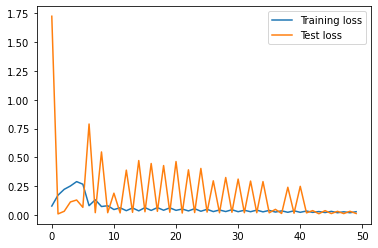

In [73]:
print(best_loss)
visualization(history)

## Predictions

In [49]:
truth, predictions, losses = [], [], []
device = torch.device("cpu")
criterion = nn.L1Loss(reduction='sum').to(device)
model.to(device)

X_test, y_test = target_seq
test_set_size = X_test.size(0)

with torch.no_grad():
    model.eval()
    for i in range(test_set_size):
        x_i = X_test[i:i+1]
        y_i = y_test[i:i+1]
        x_i.to(device)
        y_i.to(device)
        model.init_hidden(x_i.size(0), device)
        y_pred = model(x_i)
        predictions.append(y_pred.cpu().numpy().flatten())
        loss = criterion(y_pred, y_i)
        losses.append(loss.item())
        
truth = y_test.cpu().numpy().flatten()
predictions = np.array(predictions).flatten()

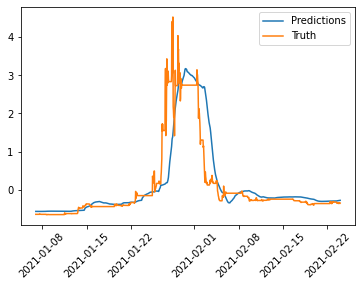

In [51]:

plt.plot(datetime_target,predictions, label="Predictions")
plt.plot(datetime_target, truth, label="Truth")
plt.xticks(rotation=45)
plt.legend()

0.25226812963176065

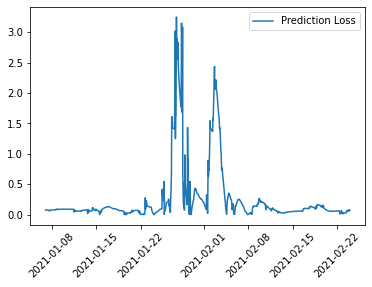

In [52]:
plt.plot(datetime_target ,losses, label="Prediction Loss")
plt.xticks(rotation=45)
plt.legend()
np.mean(losses)

In [142]:
# saving prediciton result as csv file for the entire dataset
truth, predictions, losses = [], [], []
device = torch.device("cpu")
criterion = nn.MSELoss(reduction='sum').to(device)
model.to(device)

X_test, y_test = gamestop_seq
test_set_size = X_test.size(0)

res = df_gamestop.copy()
res['predictions'] = np.nan
res['loss'] = np.nan

with torch.no_grad():
    model.eval()
    for i in range(test_set_size):
        x_i = X_test[i:i+1]
        y_i = y_test[i:i+1]
        x_i.to(device)
        y_i.to(device)
        model.init_hidden(x_i.size(0), device)
        y_pred = model(x_i)
        loss = criterion(y_pred, y_i)
        res.at[datetime_gamestop[i], 'predictions'] = y_pred.cpu().numpy().flatten()
        res.at[datetime_gamestop[i], 'predictions'] = loss.item()
        predictions.append(y_pred.cpu().numpy().flatten())
        losses.append(loss.item())
        
        
truth = y_test.cpu().numpy().flatten()
predictions = np.array(predictions).flatten()

In [146]:
res.to_csv('../foobar/data/processed/gme_predictions_m1.csv')

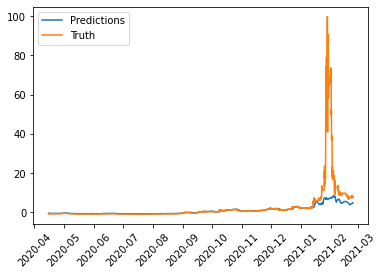

In [144]:
plt.plot(datetime_gamestop,predictions, label="Predictions")
plt.plot(datetime_gamestop, truth, label="Truth")
plt.xticks(rotation=45)
plt.legend()

In [ ]:
import os

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_index = 0
for train_window in train_window_list:
    for prediction_horizon in prediction_horizon_list:
        for feature_set in feature_sets:

            train_set, target_set = scale(df_train, df_target, feature_set)
            train_set , val_set = split(train_set, 0.8)

            train_seq, num_features = generate_window(train_set, train_window, prediction_horizon)
            val_seq, _ = generate_window(val_set, train_window, prediction_horizon)
            target_seq, _ = generate_window(target_set, train_window, prediction_horizon)

            datetime_target = test_datetime_list[train_window+prediction_horizon:]

            model = LSTM(input_size=num_features, seq_length=train_window)
            model = model.to(device)

            model, history = train_model(model, device, train_seq, val_seq)
            visualization(history, )
            model_index += 1

            print('Saving...')
            state = {
                'model': model,
                'feature_set': feature_set,
                'history': history,
                'pred_horizon': prediction_horizon,
                'train_window': train_window
            }

            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, f'./checkpoint/train_{model_index}.pth')
            
            
            plt.plot(history['train'], label="Training loss")
            plt.plot(history['val'], label="Test loss")
            plt.legend()

In [ ]:
def 

plt.plot(history['train'], label="Training loss")
plt.plot(history['val'], label="Test loss")
plt.legend()